In [51]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from collections import Counter
from wordcloud import WordCloud

In [35]:
def read_files():
    """
    Reads in all the relevant files and returns them as dataframes
    """
    X = pd.read_csv('/Users/Aansh/Documents/Brown /Research/AIMed/data/x_y_with_lace.csv')
    Y = pd.read_csv('/Users/Aansh/Documents/Brown /Research/AIMed/data/y_more_no_df_clean.csv')
    X_ICD9 = pd.read_csv('/Users/Aansh/Documents/Brown /Research/AIMed/data/patient_icd9.csv')
    icd9_d = pd.read_csv('/Users/Aansh/Documents/Brown /Research/AIMed/data/DIAGNOSES_ICD.csv')
    X_clustered = pd.read_csv('/Users/Aansh/Documents/Brown /Research/AIMed/data/labeled_clustered_data_with_ids.csv')
    codes_file = open('/Users/Aansh/Documents/Brown /Research/AIMed/icd9/codes.json')
    codes = json.load(codes_file)
    return X, X_ICD9, icd9_d, codes_file, codes, X_clustered

def map_disease_to_parent(codes):
    """
    Maps each disease to parent in ICD9 hierarchy. In absence of a parent, maps to None.
    Returns mapping of parents to children and nodes to their parents
    """
    node_to_parent = {}
    parent_to_child = {} 
    p_to_description = {}
    for i in range(len(codes)):
        grouping = codes[i]
        parent = None
        for j in range(len(grouping)):
            if grouping[j]['depth'] == 1: 
                parent = grouping[j]['code']
                if parent: 
                    description = grouping[j]['descr']
                    p_to_description[parent] = description
        for j in range(len(grouping)):
            disease_classification = grouping[j]
            code = disease_classification['code']
            depth = disease_classification['depth']
            node_to_parent[code] = parent
            curr_children = parent_to_child.get(parent, [])
            curr_children.append(code)
            parent_to_child[parent] = curr_children
    return parent_to_child, node_to_parent, p_to_description

def generate_intervals(parent_to_child):
    """
    Generates intervals for ICD9 codes to group codes in
    """
    intervals = []
    def split_intervals(key):
        for i in range(len(key)):
            if key[i] == "-": 
                if key[:i-1] and key[i+1:]: return key[:i-1], key[i+1:]
        return None
    for key, _ in parent_to_child.items():
        if key: 
            key_interval = split_intervals(key)
            if key_interval:
                intervals.append((key_interval, key))
#     print(intervals)
    return intervals

def get_parent_cluster(code, intervals):
    """
    Returns the parent cluster for a particular code. 
    case 1: code begins with an E -> parent is None
    case 2: code begins with an V -> parent is None
    case 3: code is purely numerical then should exist within intervals
    """
    if code[0] == "E" or code[0] == "V":
        return None
    for interval in intervals:
        beginning = int(interval[0][0])
        end = int(interval[0][1])
        parent_cluster = interval[1]
        if int(code[:3]) >= beginning and int(code[:3]) <= end:
            return parent_cluster
    print("Bad Code:" + code[:3])
    return None    

def get_all_subject_IDs(X_ICD9):
    """
    Returns set of all subject IDs in the dataset
    """
    all_subjects = set()
    for index, row in X_ICD9.iterrows(): all_subjects.add(row['SUBJECT_ID'])
    return all_subjects
        
def get_patient_clusters(icd9_d, X_ICD9, parent_to_child):
    """
    Returns mapping of subjects to their parent cluster for most severe condition,
    and mapping of the number of patients within each cluster.
    """
    icd9 = set()
    patients_in_clusters = {}
    not_exist = set()
    intervals = generate_intervals(parent_to_child)
    hadm_ids = []
    clusters = []
    parent_to_description = {}
    all_subjects = get_all_subject_IDs(X_ICD9)
    for index, row in icd9_d.iterrows():
        subject_id = row['SUBJECT_ID']
        hadm_id = row['HADM_ID']
        if subject_id not in all_subjects:
            continue
        if row["SEQ_NUM"] == 1.0:
            severe_code = row["ICD9_CODE"]
            icd9_parent = get_parent_cluster(severe_code, intervals)
            hadm_ids.append(hadm_id)
            clusters.append(icd9_parent)          
            patients_in_clusters[icd9_parent] = patients_in_clusters.get(icd9_parent, 0) + 1
    dict_to_df = {"hadm_id": hadm_ids, "cluster": clusters}
    return patients_in_clusters, dict_to_df

def add_cluster_to_dataframe(X, dict_to_df):
    hadm_icd9_df = pd.DataFrame.from_dict(dict_to_df)
    X_with_clusters = X.merge(hadm_icd9_df, left_on='hadm_id', right_on='hadm_id')
    return X_with_clusters

def create_cluster_csv(X_with_clusters, patients_in_clusters):
    for c in X_with_clusters['cluster'].unique():
        X_file_name = 'X_cluster_{0}.csv'.format(c) 
        Y_file_name = 'Y_cluster_{0}.csv'.format(c) 
        X_copy = X_with_clusters.copy()
        Y = X_with_clusters[X_with_clusters['cluster'] == c]['label']
        X_copy = X_copy[X_copy['cluster'] == c].drop(['label'], axis=1)
        X_copy[X_copy['cluster'] == c].to_csv(X_file_name, sep=',', index=False)
        Y.to_csv(Y_file_name, sep=',', index=False)
    return True

In [32]:
X, X_ICD9, icd9_d, codes_file, codes, X_clustered = read_files()
X = X.drop(['LACE', 'sofa'], axis=1)

In [33]:
parent_to_child, node_to_parent, p_to_description = map_disease_to_parent(codes)

In [36]:
patients_in_clusters, dict_to_df = get_patient_clusters(icd9_d, X_ICD9, parent_to_child)

In [37]:
X_with_clusters = add_cluster_to_dataframe(X, dict_to_df)

In [40]:
p_to_description

{'001-139': 'INFECTIOUS AND PARASITIC DISEASES ',
 '140-239': 'NEOPLASMS ',
 '240-279': 'ENDOCRINE, NUTRITIONAL AND METABOLIC DISEASES, AND IMMUNITY DISORDERS ',
 '280-289': 'DISEASES OF THE BLOOD AND BLOOD-FORMING ORGANS ',
 '290-319': 'MENTAL DISORDERS ',
 '320-389': 'DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS ',
 '390-459': 'DISEASES OF THE CIRCULATORY SYSTEM ',
 '460-519': 'DISEASES OF THE RESPIRATORY SYSTEM ',
 '520-579': 'DISEASES OF THE DIGESTIVE SYSTEM ',
 '580-629': 'DISEASES OF THE GENITOURINARY SYSTEM ',
 '630-679': 'COMPLICATIONS OF PREGNANCY, CHILDBIRTH, AND THE PUERPERIUM ',
 '680-709': 'DISEASES OF THE SKIN AND SUBCUTANEOUS TISSUE ',
 '710-739': 'DISEASES OF THE MUSCULOSKELETAL SYSTEM AND CONNECTIVE TISSUE ',
 '740-759': 'CONGENITAL ANOMALIES ',
 '760-779': 'CERTAIN CONDITIONS ORIGINATING IN THE PERINATAL PERIOD ',
 '780-799': 'SYMPTOMS, SIGNS, AND ILL-DEFINED CONDITIONS ',
 '800-999': 'INJURY AND POISONING '}

In [56]:
cluster_to_descriptions = {}
for index, row in X_clustered.iterrows():
    hadm_id = row['hadm_id']
    cluster_num = row['cluster_num']
    cluster = X_with_clusters[X_with_clusters['hadm_id']==hadm_id]['cluster'].values
    if not cluster: continue
    descr = p_to_description[cluster[0]]
    cluster_to_descriptions[cluster_num] = cluster_to_descriptions.get(cluster_num, []) + [descr]

/Users/Aansh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  


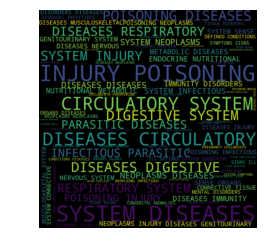

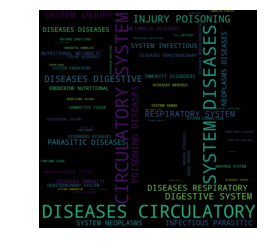

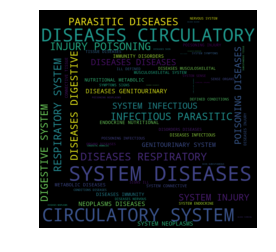

In [64]:
for cluster_num, description in cluster_to_descriptions.items():
    text = " ".join(description)
    wordcloud = WordCloud(width=1000, height=1000, margin=0).generate(text)
    fig1 = plt.gcf()
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()
    fig1.savefig("results/kmodes_wordclouds/cluster_{0}_wordcloud.png".format(cluster_num))